# NetCDF Zarr Sequential Recipe: CMIP6

This tutorial describes how to create a suitable recipe for many of the CMIP6 datasets.
The source data is a sequence of NetCDF files accessed from the 's3://esgf-world' bucket.
The target is a Zarr store.

## Background

- The s3://esgf-world bucket has about 250,000 datasets stored in about 950,000 netcdf files (for an average of about four netcdf files per dataset). This is a small subset of the WCRP-CMIP6 collection available at the Federated ESGF-COG nodes such as https://esgf-node.llnl.gov/search/cmip6, but it is faster and easier to work with. 

- Each CMIP6 dataset can be identified by a 6-tuple consisting of:

        (model,experiment,ensemble_member,mip_table,variable,grid_label)
        
and so a convenient name for a particular dataset is a string of these values joined with a '.' separator:

      dataset = model.experiment.ensemble_member.mip_table.variable.grid_label
        

- There can be multiple versions of a dataset, designated by a string beginning with 'v' and then an 8 digit date, loosely associated with its creation time

In [1]:
import pandas as pd
import xarray as xr
import s3fs

## Step 1: Get to know your source data
The CMIP6 collection is very heterogeneous, so getting to know the source data is rather complicated. We first need to identify a dataset and learn how to list the set of netcdf files which are associated with it. Fortunately, you can explore the data here: https://esgf-world.s3.amazonaws.com/index.html#CMIP6/ or download a CSV file listing all of the netcdf files, one per line.

Here we will read the CSV file into a pandas dataframe so we can search, sort and subset the available datasets and their netcdf files.

In [2]:
netcdf_cat = 's3://cmip6-nc/esgf-world.csv.gz'
df_s3 = pd.read_csv(netcdf_cat, dtype='unicode')
df_s3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949541 entries, 0 to 949540
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   project          949541 non-null  object
 1   institute        949541 non-null  object
 2   model            949541 non-null  object
 3   experiment_id    949541 non-null  object
 4   frequency        461707 non-null  object
 5   modeling_realm   461707 non-null  object
 6   mip_table        949541 non-null  object
 7   ensemble_member  949541 non-null  object
 8   grid_label       949541 non-null  object
 9   variable         949541 non-null  object
 10  temporal subset  920892 non-null  object
 11  version          949541 non-null  object
 12  path             949541 non-null  object
dtypes: object(13)
memory usage: 94.2+ MB


In [3]:
# So there are 949,541 entries, one for each netcdf file. We can see the first five here:
# The 'path' column is the most important - you may need to scroll the window to see it!

df_s3.head()

project institute    model   experiment_id frequency modeling_realm  \
0   CMIP6   AS-RCEC  TaiESM1  histSST-piNTCF       NaN            NaN   
1   CMIP6   AS-RCEC  TaiESM1  histSST-piNTCF       NaN            NaN   
2   CMIP6   AS-RCEC  TaiESM1  histSST-piNTCF       NaN            NaN   
3   CMIP6   AS-RCEC  TaiESM1  histSST-piNTCF       NaN            NaN   
4   CMIP6   AS-RCEC  TaiESM1  histSST-piNTCF       NaN            NaN   

  mip_table ensemble_member grid_label variable temporal subset    version  \
0    AERmon        r1i1p1f1         gn       ps   185001-201412  v20200318   
1     CFmon        r1i1p1f1         gn       ta   185001-201412  v20200318   
2     LImon        r1i1p1f1         gn      snc   185002-201412  v20200318   
3     LImon        r1i1p1f1         gn      snd   185002-201412  v20200318   
4     LImon        r1i1p1f1         gn      snw   185002-201412  v20200318   

                                                path  
0  s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...  
1  s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...  
2  s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...  
3  s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...  
4  s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...

In [4]:
# We will add a new column which is our short name for the datasets (may take a moment for all 949541 rows)
df_s3['dataset'] = df_s3['dataset'] = df_s3.apply(lambda row: '.'.join(row.path.split('/')[6:12]),axis=1)
# the number of unique dataset names can be found using the 'nunique' method
df_s3.dataset.nunique()

241675

In [5]:
# The value in the `path` column of the first row is:
df_s3.path.values[0]

's3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/AERmon/ps/gn/v20200318/ps_AERmon_TaiESM1_histSST-piNTCF_r1i1p1f1_gn_185001-201412.nc'

In [6]:
# which has the short name:
df_s3.dataset.values[0]

'TaiESM1.histSST-piNTCF.r1i1p1f1.AERmon.ps.gn'

In [7]:
# some datasets have multiple versions: (will just check one in each 500 of them ...)
for dataset in df_s3.dataset.unique()[::500]:
    df_dataset = df_s3[df_s3.dataset==dataset]
    if df_dataset.version.nunique() > 1:
        print(dataset,df_dataset.version.unique())

MRI-ESM2-0.piClim-SO2.r1i1p1f1.Amon.rlds.gn ['v20190912' 'v20200114']
CanESM5.historical.r23i1p1f1.Lmon.gpp.gn ['v20190306' 'v20190429']
IPSL-CM6A-LR.abrupt-4xCO2.r1i1p1f1.Lmon.cLeaf.gr ['v20180727' 'v20181005' 'v20190118']
IPSL-CM6A-LR.piControl.r1i1p1f1.CFsubhr.rsdscs.gn ['v20180802' 'v20181022']
CESM2.amip.r1i1p1f1.AERmon.mmrbc.gn ['v20190218' 'v20190319']
GFDL-CM4.abrupt-4xCO2.r1i1p1f1.Lmon.mrro.gr1 ['v20180319' 'v20180701']
CanESM5.hist-aer.r8i1p1f1.Amon.va.gn ['v20190306' 'v20190429']
CanESM5.hist-volc.r9i1p1f1.Amon.va.gn ['v20190306' 'v20190429']
CanESM5.ssp245-GHG.r9i1p1f1.Omon.fgo2.gn ['v20190306' 'v20190429']
CanESM5.ssp119.r1i1p1f1.Omon.no3.gn ['v20190306' 'v20190429']
CanESM5.ssp370.r1i1p1f1.Amon.uas.gn ['v20190306' 'v20190429']
CanESM5.ssp434.r2i1p1f1.Omon.tauvo.gn ['v20190306' 'v20190429']
CanESM5.ssp534-over.r1i1p1f1.Lmon.nbp.gn ['v20190306' 'v20190429']
CNRM-ESM2-1.ssp585.r1i1p1f2.Emon.loadss.gr ['v20190328' 'v20191021']


In [8]:
# So pick a dataset, any dataset, and try it!  N.B. some datasets are VERY large - especially the day, 6hourly, etc.
#dataset = df_s3.dataset[10450]
# or:
dataset = 'GFDL-CM4.historical.r1i1p1f1.Amon.tas.gr1'

In [9]:
df_dataset = df_s3[df_s3.dataset==dataset]
df_dataset

project  institute     model experiment_id frequency modeling_realm  \
460531   CMIP6  NOAA-GFDL  GFDL-CM4    historical       mon          atmos   
460532   CMIP6  NOAA-GFDL  GFDL-CM4    historical       mon          atmos   
460533   CMIP6  NOAA-GFDL  GFDL-CM4    historical       mon          atmos   

       mip_table ensemble_member grid_label variable temporal subset  \
460531      Amon        r1i1p1f1        gr1      tas   185001-185412   
460532      Amon        r1i1p1f1        gr1      tas   185001-194912   
460533      Amon        r1i1p1f1        gr1      tas   195001-201412   

          version                                               path  \
460531  v20180301  s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/...   
460532  v20180701  s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/...   
460533  v20180701  s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/...   

                                          dataset  
460531  GFDL-CM4.historical.r1i1p1f1.Amon.tas.gr1  
460532  GFDL-CM4.historical.r1i1p1f1.Amon.tas.gr1  
460533  GFDL-CM4.historical.r1i1p1f1.Amon.tas.gr1

**So is this what we expect?**
- this dataset is split over 3 netcdf files - see any trouble here?
- lets do a quick sanity check (make sure one and only one variable is specified) and get only the latest version of the files

In [10]:
dvars = df_dataset.variable.unique()
assert len(dvars) > 0, 'no netcdf files found for this dataset'
assert len(dvars) == 1, f"trouble with this dataset, too many datasets found: {dvars}"
    
var = dvars[0]
print('The variable is:',var)

# make sure we are looking at the last available version:
last_version = sorted(df_dataset.version.unique())[-1]
dze = df_dataset[df_dataset.version == last_version].reset_index(drop=True)

input_urls = sorted(dze.path.unique())
input_urls

The variable is: tas


['s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-CM4_historical_r1i1p1f1_gr1_185001-194912.nc',
 's3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-CM4_historical_r1i1p1f1_gr1_195001-201412.nc']

**There are only two files - one netcdf file was from an older version!**
- We want to look at the first netcdf file to make sure we know what to expect
- To use `xarray.open_dataset`, we need to turn the input_url (starting with 's3://') into an appropriate file_like object.

In [11]:
# Connect to AWS S3 storage
fs_s3 = s3fs.S3FileSystem(anon=True)

file_url = fs_s3.open(input_urls[0], mode='rb')
ds = xr.open_dataset(file_url)
print(ds)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1200)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time       (time) object 1850-01-16 12:00:00 ... 1949-12-16 12:00:00
Data variables:
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) object ...
Attributes: (12/46)
    external_variables:     areacella
    history:                File was processed by fremetar (GFDL analog of CM...
    table_id:               Amon
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   [0.]
    ...                     ...
    variable_id:            tas
    variant_info:           N/A
    references:             see further_info_url attribute
    varian

## Step 2: Deciding how to chunk the dataset
- For parallel I/O and subsetting the dataset in time, we will chunk the data in the time dimension
- In order to figure out the number of time slices in each chunk, we do a small calculation on the first netcdf file
- Here we set the desired chunk size to 50 Mb, but something between 50-100 Mb is usually alright

In [12]:
ntime = len(ds.time)       # the number of time slices
chunksize_optimal = 50e6  # desired chunk size in bytes
ncfile_size = ds.nbytes    # the netcdf file size
chunksize = max(int(ntime* chunksize_optimal/ ncfile_size),1)

target_chunks = ds.dims.mapping
target_chunks['time'] = chunksize

target_chunks   # a dictionary giving the chunk sizes in each dimension

SortedKeysDict({'bnds': 2, 'lat': 180, 'lon': 288, 'time': 241})

## Step 3: Define a pre-processing function
- This is an optional step which we want to apply to each chunk
- Here we change some data variables into coordinate variables, but you can define your own pre-processing step here

In [13]:
# the netcdf lists some of the coordinate variables as data variables. This is a fix which we want to apply to each chunk.
def set_bnds_as_coords(ds):
    new_coords_vars = [var for var in ds.data_vars if 'bnds' in var or 'bounds' in var]
    ds = ds.set_coords(new_coords_vars)
    return ds

## Step 4: Choose and define the recipe
- The list of input_urls, the sequence_dim and target_chunks are specified as in previous tutorial
- These netcdf files do not contain a fixed number of time slices in each file, so we set `nitems_per_input = None`
- Some datasets have inconsistent coordinates between the various netcdf files (staggered). In this case, we want the recipe to fail
- The current recipe fails for some files unless we use `xarray_open_kwargs = {'decode_coords':False}`

In [14]:
# Choose a Recipe:
from pangeo_forge.recipe import NetCDFtoZarrSequentialRecipe

recipe = NetCDFtoZarrSequentialRecipe(
    input_urls = input_urls,
    sequence_dim = "time", 
    target_chunks = target_chunks,
    nitems_per_input = None, 
    process_chunk = set_bnds_as_coords,
    #xarray_open_kwargs = {'decode_coords':False},
    xarray_concat_kwargs = {'join':'exact'}
)

## Step 5: Create storage targets
- Here we are caching the netcdf files locally
- We also need a temporary metadata cache because we don't know in advance how many time slices are in each netcdf file

In [15]:
import tempfile
from fsspec.implementations.local import LocalFileSystem
from pangeo_forge.storage import FSSpecTarget, CacheFSSpecTarget

fs_local = LocalFileSystem()

target_dir = tempfile.TemporaryDirectory()
target = FSSpecTarget(fs_local, target_dir.name)

cache_dir = tempfile.TemporaryDirectory()
cache_target = CacheFSSpecTarget(fs_local, cache_dir.name)

meta_dir = tempfile.TemporaryDirectory()
meta_store = FSSpecTarget(fs_local, meta_dir.name)

recipe.target = target
recipe.input_cache = cache_target
recipe.metadata_cache = meta_store

cache_target.root_path, target.root_path, meta_store.root_path

('/tmp/tmpqmzj3ohx', '/tmp/tmpfw877ivt', '/tmp/tmpvenpqlsy')

## Step 6: Execute the recipe

In [16]:
import zarr

if True:
    # if caching the input:  (must also use if metadata_caching?)
    for input_name in recipe.iter_inputs():
        recipe.cache_input(input_name)

    # use recipe to create the zarr store:
    recipe.prepare_target() 
    
    # is it there?
    zgroup = zarr.open(target_dir.name)
    print(zgroup.tree())
    
    for chunk in recipe.iter_chunks():
        recipe.store_chunk(chunk)
    recipe.finalize_target()

/
 ├── bnds (2,) float64
 ├── height () float64
 ├── lat (180,) float64
 ├── lat_bnds (180, 2) float64
 ├── lon (288,) float64
 ├── lon_bnds (288, 2) float64
 ├── tas (1980, 180, 288) float32
 ├── time (1980,) int64
 └── time_bnds (1980, 2) int64


## Step 7: Check the resulting Zarr store

In [17]:
# Check to see if it worked:
ds = xr.open_zarr(target_dir.name)
print(ds)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1980)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(241, 2), meta=np.ndarray>
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(241, 180, 288), meta=np.ndarray>
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ..

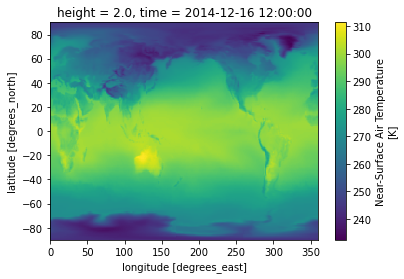

In [18]:
ds[var][-1].plot()

## Postscript
- If you find a CMIP6 dataset for which this recipe does not work, Please report it at [issue#105](https://github.com/pangeo-forge/pangeo-forge/issues/105) so we can refine the recipe, if possible.


In [19]:
# Troubles found:

dataset = 'IPSL-CM6A-LR.abrupt-4xCO2.r1i1p1f1.Lmon.cLeaf.gr'  # need decode_coords=False in xr.open_dataset, but using xarray_open_kwargs = {'decode_coords':False}, still throws an error when caching the input 